# Linear Regression

In [71]:
 #library imports 
import pandas as pd  
import pandasql
import numpy as np  

from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm
import scipy.stats as stats 
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns  

import warnings
warnings.filterwarnings('ignore') 

## Data Initialization and Visualization
Import the data and visualize 

In [72]:
%store -r ols_df
ols_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city,bed_bath
0,7129300520,221900.0,3,1.00,7.073270,8.639411,1.0,0.0,0.0,3,...,1,1.0,98178,47.5112,-122.257,7.200425,8.639411,4966,0,4.00
2,5631500400,180000.0,2,1.00,6.646391,9.210340,1.0,0.0,0.0,3,...,0,1.0,98028,47.7379,-122.233,7.908387,8.994917,3606,1,3.00
3,2487200875,604000.0,4,3.00,7.580700,8.517193,1.0,0.0,0.0,5,...,1,1.0,98136,47.5208,-122.393,7.215240,8.517193,6425,0,7.00
4,1954400510,510000.0,3,2.00,7.426549,8.997147,1.0,0.0,0.0,3,...,1,1.0,98074,47.6168,-122.045,7.495542,8.923058,2411,1,5.00
6,1321400060,257500.0,3,2.25,7.447168,8.827468,2.0,0.0,0.0,3,...,1,1.0,98003,47.3097,-122.327,7.713338,8.827468,3800,1,5.25


In [73]:
#copy working df to a df called: lr_df
ols_df = ols_df.drop(['id'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DFB3007EB0>,
      dtype=object)

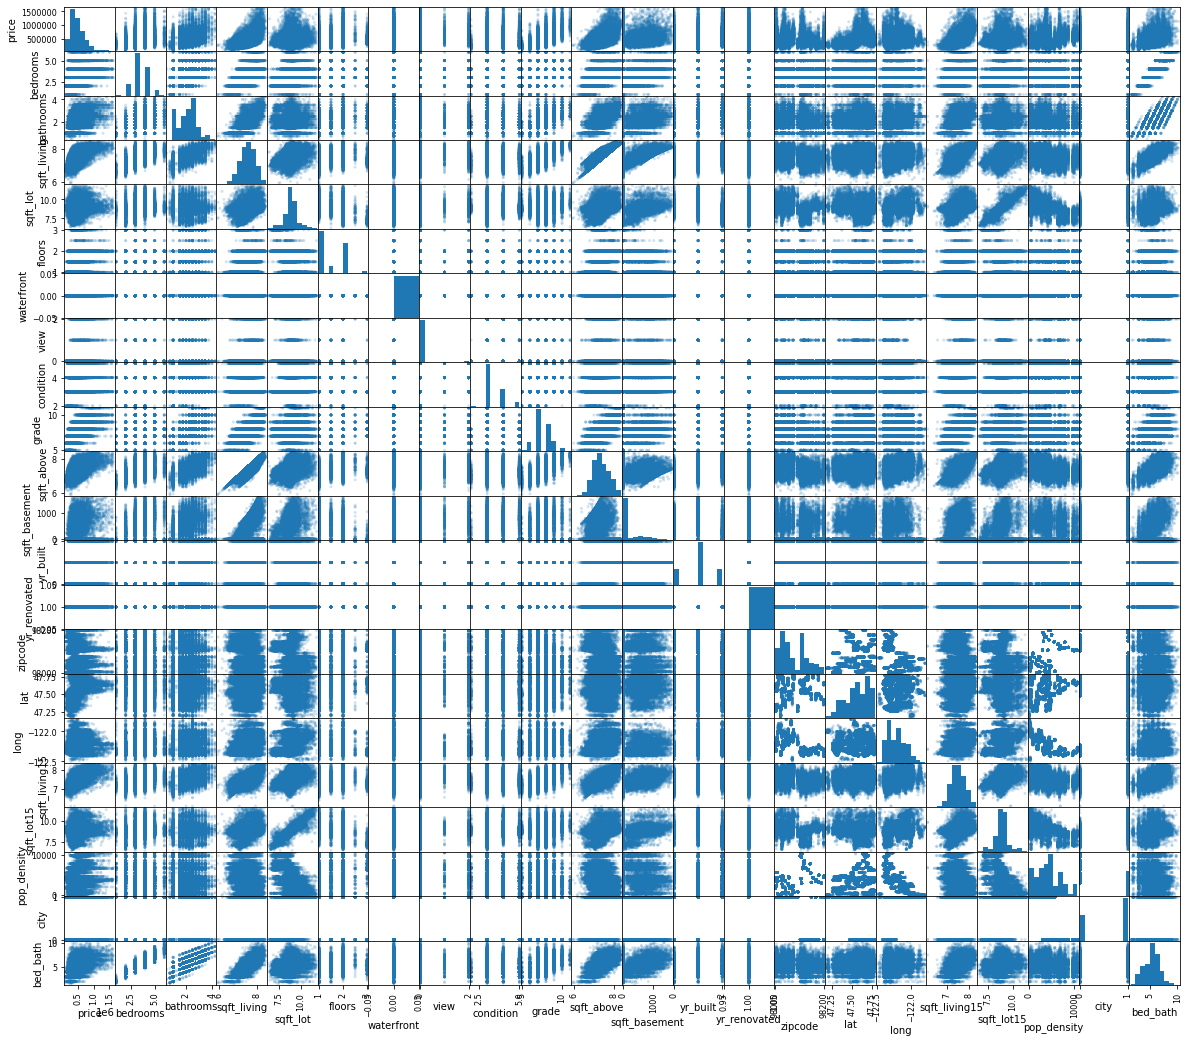

In [74]:
#data distribution visualization  
pd.plotting.scatter_matrix(ols_df, alpha=0.2, figsize=(20,18))

## Functions

In [75]:
def correlation_check(x_cols, df, outcome='price'):  
    """outcome= taget column name
        x_cols - independent variables 
        df = working dataframe 
        
        Returns:
        correlation 
        heatmap 
        """
    #correlation check
    feats = x_cols 
    corr = df[feats].corr()  
    
    #heatmap 
    sns.heatmap(corr, center=0, annot=True)   
     
    print("Correlation:", corr)

In [76]:
def reg_line (m, c, X):
    
    return [(m*x)+c for x in X]

In [54]:
def linear_regression(x_cols, df, outcome='price'):  
    """outcome= taget column name
        x_cols - independent variables 
        df = working dataframe 
        
        returns 
        baseline R2 
        OLS Model Summary 
        VIF scores 
        QQPlot 
        Pvalues Table"""

    #baseline model 
    y = df[['price']]
    X = df.drop(['price'], axis=1) 

    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1) 
    
    baseline= np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
    baseline 
    
    #fit model 
    predictors = '+'.join(x_cols) 
    formula = outcome + "~" + predictors
    model = ols(formula=formula, data=df).fit()
    model.summary() 
    
    #vif scores
    X = df[x_cols] 
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  
    
    #normality check
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)  
    
    #pvalues
    summary = model.summary()
    p_table = summary.tables[1]
    p_table = pd.DataFrame(p_table.data)
    p_table.columns = p_table.iloc[0]
    p_table = p_table.drop(0)
    p_table = p_table.set_index(p_table.columns[0])
    p_table['P>|t|'] = p_table['P>|t|'].astype(float)
    x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
    x_cols.remove('Intercept')
    
    print("Baseline:", baseline)  
    print(model.summary()) 
    print("\n")
    print("Vif Scores:", list(zip(x_cols, vif)))   
    print("\n")
    print(len(p_table), len(x_cols))
    print(x_cols[:5])
    print(p_table.head())

In [55]:
def build_sm_ols(df, features_to_use, target, add_constant=False, show_summary=True):
    X = df[features_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols

# assumptions of ols
# residuals are normally distributed
def check_residuals_normal(ols):
    residuals = ols.resid
    t, p = stats.shapiro(residuals)
    if p <= 0.05:
        return False
    return True


# residuals are homoskedasticitous
def check_residuals_homoskedasticity(ols):
    import statsmodels.stats.api as sms
    resid = ols.resid
    exog = ols.model.exog
    lg, p, f, fp = sms.het_breuschpagan(resid=resid, exog_het=exog)
    if p >= 0.05:
        return True
    return False




def check_vif(df, features_to_use, target_feature):
    ols = build_sm_ols(df=df, features_to_use=features_to_use, target=target_feature, show_summary=False)
    r2 = ols.rsquared
    return 1 / (1 - r2)
    
    
    
# no multicollinearity in our feature space
def check_vif_feature_space(df, features_to_use, vif_threshold=3.0):
    all_good_vif = True
    for feature in features_to_use:
        target_feature = feature
        _features_to_use = [f for f in features_to_use if f!=target_feature]
        vif = check_vif(df=df, features_to_use=_features_to_use, target_feature=target_feature)
        if vif >= vif_threshold:
            print(f"{target_feature} surpassed threshold with vif={vif}")
            all_good_vif = False
    return all_good_vif
        
        


def check_model(df, 
                features_to_use, 
                target_col, 
                add_constant=False, 
                show_summary=False, 
                vif_threshold=3.0):
    has_multicollinearity = check_vif_feature_space(df=df, 
                                                    features_to_use=features_to_use, 
                                                    vif_threshold=vif_threshold)
    if not has_multicollinearity:
        print("Model contains multicollinear features")
    
    
    # check residuals
    resids_are_norm = check_residuals_normal(ols)
    resids_are_homo = check_residuals_homoskedasticity(ols)
    
    if not resids_are_norm or not resids_are_homo:
        print("Residuals failed test/tests")
    return ols

In [56]:
def corr_function(x, y):
    try:
        return x.corr(y)
    except:
        return None

In [57]:
outcome = "price"

## Identifying Correlated Features

In [58]:
# seperate data by correlation values

columns_correlations = []
columns_non_numeric = []

for column in ols_df.drop(columns=[outcome]).columns:
    try:
        corr = np.abs(ols_df[column].corr(ols_df[outcome]))
        t = (column, corr)
        columns_correlations.append(t)
    except:
        columns_non_numeric.append(column) 
columns_correlations

[('bedrooms', 0.10434593451556771),
 ('bathrooms', 0.3382766099603356),
 ('sqft_living', 0.5812063301793765),
 ('sqft_lot', 0.08464563373708954),
 ('floors', 0.24974821622710322),
 ('waterfront', nan),
 ('view', 0.17081361593439634),
 ('condition', 0.02131168611179891),
 ('grade', 0.6411262202878875),
 ('sqft_above', 0.5076702938769083),
 ('sqft_basement', nan),
 ('yr_built', 0.07182458741074497),
 ('yr_renovated', nan),
 ('zipcode', 0.04450589127797812),
 ('lat', 0.42261790465147775),
 ('long', 0.07874225267805993),
 ('sqft_living15', 0.5363112512092129),
 ('sqft_lot15', 0.07825670363744333),
 ('pop_density', 0.10071809036770503),
 ('city', 0.04517926645086125),
 ('bed_bath', 0.31579920287286073)]

In [61]:
correlated_features_above_2 = [t[0] for t in columns_correlations if t[1] >= 0.20]
correlated_features_above_2

['bathrooms',
 'sqft_living',
 'floors',
 'grade',
 'sqft_above',
 'lat',
 'sqft_living15',
 'bed_bath']

## Trial 1 
All columns that were correlated above 0.20

In [64]:
#redefine the problem 
outcome = 'price'
t1 = ['bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'bed_bath']

In [68]:
ols_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city,bed_bath
0,221900.0,0,1.00,0.671067,0.768410,1.0,0.0,0.0,0,4,...,1,1.0,98178,47.5112,-122.257,0.680133,0.768410,2.141285,0,1.00
2,180000.0,2,1.00,0.638730,0.797654,1.0,0.0,0.0,0,3,...,0,1.0,98028,47.7379,-122.233,0.726545,0.786938,2.102957,1,3.00
3,604000.0,1,0.00,0.705869,0.761781,1.0,0.0,0.0,2,4,...,1,1.0,98136,47.5208,-122.393,0.681174,0.761781,2.171103,0,1.00
4,510000.0,0,2.00,0.695675,0.787051,1.0,0.0,0.0,0,5,...,1,1.0,98074,47.6168,-122.045,0.700276,0.783280,2.052558,1,2.00
6,257500.0,0,2.25,0.697056,0.778347,2.0,0.0,0.0,0,4,...,1,1.0,98003,47.3097,-122.327,0.714395,0.778347,2.109335,1,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,0,2.50,0.689334,0.667988,0.0,0.0,0.0,0,5,...,2,1.0,98103,47.6993,-122.346,0.689334,0.688387,2.219290,0,2.50
21593,400000.0,1,2.50,0.716399,0.769933,2.0,0.0,0.0,0,5,...,2,1.0,98146,47.5107,-122.362,0.701369,0.781162,2.154745,0,3.50
21594,402101.0,2,0.75,0.660369,0.680656,2.0,0.0,0.0,0,4,...,2,1.0,98144,47.5944,-122.299,0.660369,0.707408,2.194330,0,2.75
21595,400000.0,0,2.50,0.692382,0.718487,2.0,0.0,0.0,0,5,...,2,1.0,98027,47.5345,-122.069,0.683696,0.677282,1.816550,1,2.50


In [ ]:
def calc_slope(xs, ys):

    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)**2) - np.mean(xs*xs)))
    
    return m

def best_fit(xs, ys):

    m = calc_slope(xs, ys)
    c = np.mean(ys) - m*np.mean(xs)
    
    return m, c

def reg_line (m, c, X):
    
    return [(m*x)+c for x in X]

def sum_sq_err(ys_real, ys_predicted):

    sse =  sum((ys_predicted - ys_real) * (ys_predicted - ys_real))
    
    return sse

def r_squared(ys_real, ys_predicted):
    
    # Calculate Y_mean , squared error for regression and mean line , and calculate r-squared
    y_mean = [np.mean(ys_real) for y in ys_real]

    sq_err_reg = sum_sq_err(ys_real, ys_predicted)
    sq_err_y_mean = sum_sq_err(ys_real, y_mean)
    
    # Calculate r-squared 
    r_sq =  1 - (sq_err_reg/sq_err_y_mean)
    
    return r_sq

def plot_reg(X, Y, Y_pred):
    plt.scatter(X, Y, color='#003F72', label='data')
    plt.plot(X, Y_pred, label='regression line')
    plt.legend(loc=4)
    plt.show()
    return None

X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.float64)
Y = np.array([7, 7, 8, 9, 9, 10, 10, 11, 11, 12], dtype=np.float64)

m, c = best_fit(X, Y)
Y_pred = reg_line(m, c, X)
r_squared = r_squared(Y, Y_pred)

print ('Basic Regression Diagnostics')
print ('----------------------------')
print ('Slope:', round(m, 2))
print ('Y-Intercept:', round(c, 2))
print ('R-Squared:', round(r_squared, 2))
print ('----------------------------')
print ('Model: Y =',round(m, 2),'* X +', round(c, 2))

plot_reg(X, Y, Y_pred)

In [69]:
y = ols_df[['price']]
X = ols_df.drop(['price'], axis=1) 

regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1) 

baseline= np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
baseline 

nan

Baseline: nan
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3386.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        06:59:02   Log-Likelihood:            -2.4320e+05
No. Observations:               18244   AIC:                         4.864e+05
Df Residuals:                   18235   BIC:                         4.865e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.132e+07   3.88e

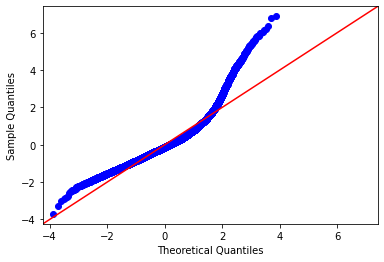

In [66]:
linear_regression(x_cols=t1, df=ols_df, outcome='price')

## Trial 2 
Remove 'sqft_basement' it has a vif score of 670 indicating high multicollinearity

In [29]:
outcome = 'price'
t2 = ['sqft_living', 'floors', 'grade', 'sqft_above', 'lat', 'sqft_living15']

In [34]:
linear_regression(x_cols=t2, df=trial1, outcome='price')

TypeError: 'RegressionResultsWrapper' object is not callable